In [1]:
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

# Đọc dữ liệu từ các file CSV
train_df = pd.read_csv('train_outputs_labels.csv')
valid_df = pd.read_csv('valid_outputs_labels.csv')

# In ra thông tin dữ liệu
print("Training Data:")
print(train_df.head())
print("\nValidation Data:")
print(valid_df.head())

Training Data:
          0         1         2         3         4         5         6  \
0 -1.490288 -2.131715  2.675470  0.356039 -1.438886  1.302458 -2.569753   
1 -2.912251 -2.418226  5.662787 -5.017981  2.217197  1.657687 -4.551850   
2 -3.385920  1.132001  1.499515 -7.853797  2.328621  3.351565 -7.272296   
3 -4.211699  0.558090  3.278892 -4.618129  1.554902  2.090884 -6.557449   
4 -5.462452 -3.170148  8.515624 -3.153387  0.237360  2.452388 -6.336083   

          7         8         9  ...        30        31        32        33  \
0  1.141482  1.526951 -1.229647  ...  1.202276 -0.598627 -0.078268 -0.276804   
1  2.084362  2.307883 -5.699462  ... -6.287863 -0.871585  5.575568 -6.203459   
2  3.164227  2.386287 -2.541138  ... -4.501150  1.407243  2.225735 -6.239211   
3  2.046200  2.906623 -8.311022  ... -5.027571  1.174167  3.464464 -4.435229   
4 -2.034015  7.305467 -5.822098  ... -5.826168 -0.438045  5.828811 -2.602424   

         34        35        36        37        38  

In [2]:
import torch
# Tính toán số lượng mẫu của mỗi lớp
class_counts = train_df['label'].value_counts()
total_samples = len(train_df)
class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}

# In ra thông tin trọng số
print("Class Weights (inverse frequency):")
print(class_weights)

# Chuyển đổi trọng số nhãn thành tensor
class_weights_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float)

Class Weights (inverse frequency):
{2: 0.7697649572649573, 1: 1.1118827160493827, 0: 1.2476190476190476}


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Chia dữ liệu thành các tensor
X_train = torch.tensor(train_df.iloc[:, :-1].values, dtype=torch.float32)
y_train = torch.tensor(train_df['label'].values, dtype=torch.long)
X_valid = torch.tensor(valid_df.iloc[:, :-1].values, dtype=torch.float32)
y_valid = torch.tensor(valid_df['label'].values, dtype=torch.long)

# Tạo DataLoader
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

# Định nghĩa mô hình (ví dụ dùng mạng neural cơ bản)
class H39_97_ANN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(H39_97_ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 97)
        # self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(97, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        # x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Khởi tạo mô hình, hàm loss và optimizer
input_dim = X_train.shape[1]
output_dim = len(class_weights)
model = H39_97_ANN(input_dim, output_dim)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện mô hình
num_epochs = 100
best_valid_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Đánh giá mô hình trên tập validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)

    valid_loss /= len(valid_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {valid_loss:.4f}")

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model_H39_97_ANN_withoutAug.pth')


Epoch 1/100, Validation Loss: 0.2447
Epoch 2/100, Validation Loss: 0.2574
Epoch 3/100, Validation Loss: 0.2656
Epoch 4/100, Validation Loss: 0.2735
Epoch 5/100, Validation Loss: 0.2781
Epoch 6/100, Validation Loss: 0.2802
Epoch 7/100, Validation Loss: 0.2929
Epoch 8/100, Validation Loss: 0.2887
Epoch 9/100, Validation Loss: 0.2909
Epoch 10/100, Validation Loss: 0.2946
Epoch 11/100, Validation Loss: 0.2926
Epoch 12/100, Validation Loss: 0.2996
Epoch 13/100, Validation Loss: 0.3067
Epoch 14/100, Validation Loss: 0.3045
Epoch 15/100, Validation Loss: 0.3078
Epoch 16/100, Validation Loss: 0.3105
Epoch 17/100, Validation Loss: 0.3168
Epoch 18/100, Validation Loss: 0.3182
Epoch 19/100, Validation Loss: 0.3232
Epoch 20/100, Validation Loss: 0.3178
Epoch 21/100, Validation Loss: 0.3271
Epoch 22/100, Validation Loss: 0.3335
Epoch 23/100, Validation Loss: 0.3352
Epoch 24/100, Validation Loss: 0.3445
Epoch 25/100, Validation Loss: 0.3442
Epoch 26/100, Validation Loss: 0.3391
Epoch 27/100, Validat


AUC Scores for each class:
0.9812746365045134

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        97
           1       0.83      0.88      0.86       109
           2       0.91      0.89      0.90       157

    accuracy                           0.90       363
   macro avg       0.91      0.91      0.91       363
weighted avg       0.91      0.90      0.90       363



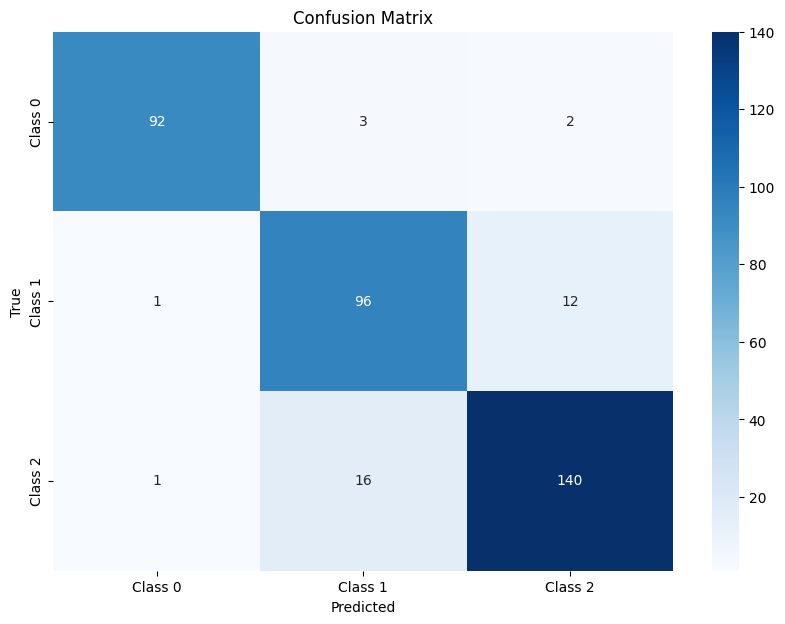

In [5]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

# Load mô hình tốt nhất
model.load_state_dict(torch.load('best_model_H39_97_ANN_withoutAug.pth', weights_only=True))

# Dự đoán trên tập validation
model.eval()
y_true = []
y_pred = []
y_pred_prob = []  # Lưu xác suất dự đoán cho AUC
with torch.no_grad():
    for inputs, labels in valid_loader:
        outputs = model(inputs)
        prob = F.softmax(outputs, dim=1)  # Chuyển đổi đầu ra thành xác suất
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())
        y_pred_prob.extend(prob.numpy())  # Lưu xác suất dự đoán

# Chuyển đổi danh sách thành mảng NumPy
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_prob = np.array(y_pred_prob)

# Tính toán confusion matrix và classification report
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred)

# Tính toán AUC cho từng lớp
try:
    auc_scores = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')
    print("\nAUC Scores for each class:")
    print(auc_scores)
except ValueError as e:
    print(f"ValueError: {e}")

print("\nClassification Report:")
print(class_report)

# Vẽ confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [6]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight

# Giả sử X_train và y_train đã được định nghĩa từ trước
def augment_data(X):
    jitter = np.random.normal(0, 0.01, X.shape)
    X_augmented = X + jitter
    return X_augmented

# Tăng cường dữ liệu lên gấp 20 lần
def augment_data_multiple_times(X, num_repeats=20):
    augmented_data = [X]
    for _ in range(num_repeats - 1):
        augmented_data.append(augment_data(X))
    X_augmented = np.concatenate(augmented_data, axis=0)
    return X_augmented

# Chuyển đổi dữ liệu của bạn thành numpy array nếu chưa có
X_train_np = X_train.numpy()
y_train_np = y_train.numpy()

# Tăng cường dữ liệu
X_train_augmented_np = augment_data_multiple_times(X_train_np, num_repeats=20)
y_train_augmented_np = np.tile(y_train_np, 20)  # Lặp lại nhãn tương ứng

# Chuyển đổi lại thành tensor
X_train_augmented = torch.tensor(X_train_augmented_np, dtype=torch.float32)
y_train_augmented = torch.tensor(y_train_augmented_np, dtype=torch.long)

# Tạo DataLoader mới cho dữ liệu tăng cường
train_dataset_augmented = TensorDataset(X_train_augmented, y_train_augmented)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=64, shuffle=True)

In [7]:
# Tính toán trọng số của các lớp cho dữ liệu tăng cường
augmented_class_counts = np.bincount(y_train_augmented_np)
total_augmented_samples = len(y_train_augmented_np)
augmented_class_weights = {cls: total_augmented_samples / (len(augmented_class_counts) * count)
                           for cls, count in enumerate(augmented_class_counts)}

# In ra số lượng mẫu và trọng số của các lớp sau khi tăng cường
print("Number of samples per class after augmentation:")
for cls, count in enumerate(augmented_class_counts):
    print(f"Class {cls}: {count} samples")

print("\nClass Weights (inverse frequency) for augmented data:")
print(augmented_class_weights)

Number of samples per class after augmentation:
Class 0: 7700 samples
Class 1: 8640 samples
Class 2: 12480 samples

Class Weights (inverse frequency) for augmented data:
{0: 1.2476190476190476, 1: 1.1118827160493827, 2: 0.7697649572649573}


In [8]:
# Khởi tạo mô hình, hàm loss và optimizer
input_dim = X_train.shape[1]
output_dim = len(class_weights)
model = H39_97_ANN(input_dim, output_dim)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện mô hình
num_epochs = 100
best_valid_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader_augmented:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Đánh giá mô hình trên tập validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)

    valid_loss /= len(valid_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {valid_loss:.4f}")

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model_H39_97_ANN_withAug.pth')


Epoch 1/100, Validation Loss: 0.3397
Epoch 2/100, Validation Loss: 0.3932
Epoch 3/100, Validation Loss: 0.4485
Epoch 4/100, Validation Loss: 0.5044
Epoch 5/100, Validation Loss: 0.5565
Epoch 6/100, Validation Loss: 0.6130
Epoch 7/100, Validation Loss: 0.6881
Epoch 8/100, Validation Loss: 0.7231
Epoch 9/100, Validation Loss: 0.8204
Epoch 10/100, Validation Loss: 0.8540
Epoch 11/100, Validation Loss: 0.8706
Epoch 12/100, Validation Loss: 0.9464
Epoch 13/100, Validation Loss: 0.9611
Epoch 14/100, Validation Loss: 1.0223
Epoch 15/100, Validation Loss: 1.0643
Epoch 16/100, Validation Loss: 1.0850
Epoch 17/100, Validation Loss: 1.1607
Epoch 18/100, Validation Loss: 1.1832
Epoch 19/100, Validation Loss: 1.2511
Epoch 20/100, Validation Loss: 1.2431
Epoch 21/100, Validation Loss: 1.3329
Epoch 22/100, Validation Loss: 1.3507
Epoch 23/100, Validation Loss: 1.4322
Epoch 24/100, Validation Loss: 1.4559
Epoch 25/100, Validation Loss: 1.5251
Epoch 26/100, Validation Loss: 1.4939
Epoch 27/100, Validat


AUC Scores for each class:
0.9808784993393814

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        97
           1       0.82      0.90      0.86       109
           2       0.93      0.89      0.91       157

    accuracy                           0.91       363
   macro avg       0.91      0.91      0.91       363
weighted avg       0.91      0.91      0.91       363



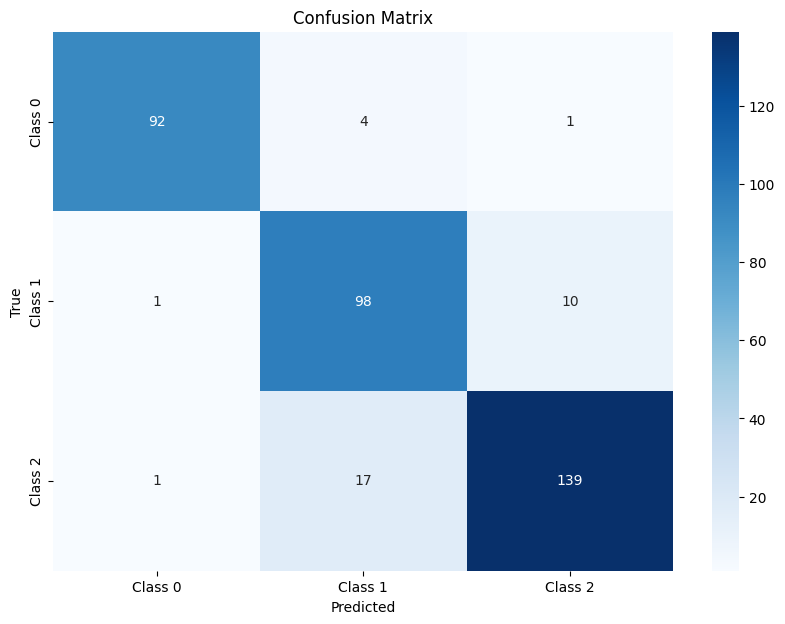

In [10]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

# Load mô hình tốt nhất
model.load_state_dict(torch.load('best_model_H39_97_ANN_withAug.pth', weights_only=True))

# Dự đoán trên tập validation
model.eval()
y_true = []
y_pred = []
y_pred_prob = []  # Lưu xác suất dự đoán cho AUC
with torch.no_grad():
    for inputs, labels in valid_loader:
        outputs = model(inputs)
        prob = F.softmax(outputs, dim=1)  # Chuyển đổi đầu ra thành xác suất
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())
        y_pred_prob.extend(prob.numpy())  # Lưu xác suất dự đoán

# Chuyển đổi danh sách thành mảng NumPy
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_prob = np.array(y_pred_prob)

# Tính toán confusion matrix và classification report
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred)

# Tính toán AUC cho từng lớp
try:
    auc_scores = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')
    print("\nAUC Scores for each class:")
    print(auc_scores)
except ValueError as e:
    print(f"ValueError: {e}")

print("\nClassification Report:")
print(class_report)

# Vẽ confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [12]:
class H39_97_97_ANN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(H39_97_97_ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 97)
        self.fc2 = nn.Linear(97, 97)
        self.fc3 = nn.Linear(97, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Khởi tạo mô hình, hàm loss và optimizer
input_dim = X_train.shape[1]
output_dim = len(class_weights)
model = H39_97_97_ANN(input_dim, output_dim)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện mô hình
num_epochs = 100
best_valid_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader_augmented:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Đánh giá mô hình trên tập validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)

    valid_loss /= len(valid_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {valid_loss:.4f}")

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model_H39_97_97_ANN_withAug.pth')


Epoch 1/100, Validation Loss: 0.3834
Epoch 2/100, Validation Loss: 0.5128
Epoch 3/100, Validation Loss: 0.5742
Epoch 4/100, Validation Loss: 0.6945
Epoch 5/100, Validation Loss: 0.8342
Epoch 6/100, Validation Loss: 0.9224
Epoch 7/100, Validation Loss: 1.0684
Epoch 8/100, Validation Loss: 1.1549
Epoch 9/100, Validation Loss: 1.1895
Epoch 10/100, Validation Loss: 1.3969
Epoch 11/100, Validation Loss: 1.4500
Epoch 12/100, Validation Loss: 1.6007
Epoch 13/100, Validation Loss: 1.7112
Epoch 14/100, Validation Loss: 1.8171
Epoch 15/100, Validation Loss: 1.9218
Epoch 16/100, Validation Loss: 2.0238
Epoch 17/100, Validation Loss: 2.0593
Epoch 18/100, Validation Loss: 2.1608
Epoch 19/100, Validation Loss: 2.2694
Epoch 20/100, Validation Loss: 2.3928
Epoch 21/100, Validation Loss: 2.4946
Epoch 22/100, Validation Loss: 2.5028
Epoch 23/100, Validation Loss: 2.5997
Epoch 24/100, Validation Loss: 2.7310
Epoch 25/100, Validation Loss: 2.7849
Epoch 26/100, Validation Loss: 2.9361
Epoch 27/100, Validat


AUC Scores for each class:
0.9806291765713641

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        97
           1       0.84      0.84      0.84       109
           2       0.89      0.92      0.91       157

    accuracy                           0.90       363
   macro avg       0.91      0.90      0.90       363
weighted avg       0.90      0.90      0.90       363



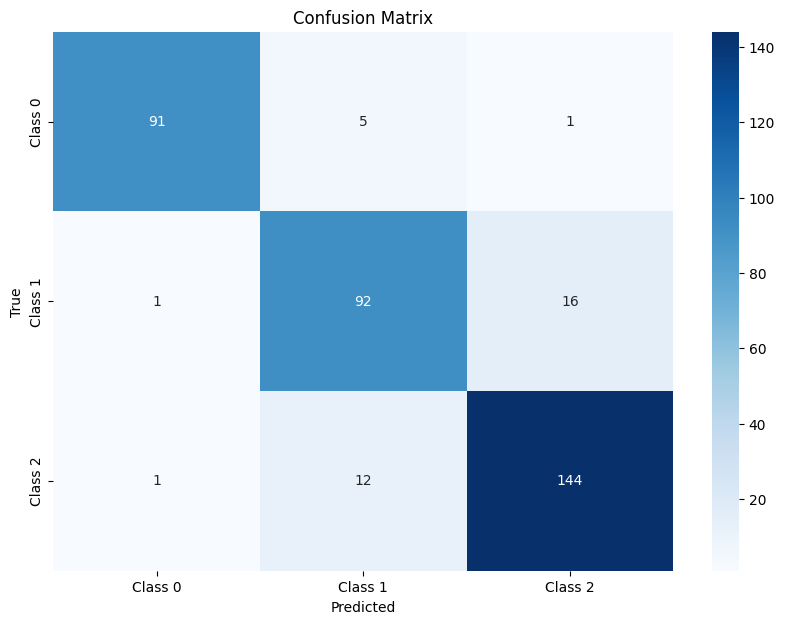

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

# Load mô hình tốt nhất
model.load_state_dict(torch.load('best_model_H39_97_97_ANN_withAug.pth', weights_only=True))

# Dự đoán trên tập validation
model.eval()
y_true = []
y_pred = []
y_pred_prob = []  # Lưu xác suất dự đoán cho AUC
with torch.no_grad():
    for inputs, labels in valid_loader:
        outputs = model(inputs)
        prob = F.softmax(outputs, dim=1)  # Chuyển đổi đầu ra thành xác suất
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())
        y_pred_prob.extend(prob.numpy())  # Lưu xác suất dự đoán

# Chuyển đổi danh sách thành mảng NumPy
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_prob = np.array(y_pred_prob)

# Tính toán confusion matrix và classification report
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred)

# Tính toán AUC cho từng lớp
try:
    auc_scores = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')
    print("\nAUC Scores for each class:")
    print(auc_scores)
except ValueError as e:
    print(f"ValueError: {e}")

print("\nClassification Report:")
print(class_report)

# Vẽ confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()